In [1]:
import pandas as pd
import scipy.io
import numpy as np
from pyvis.network import Network
import matplotlib.pyplot as plt
import collections
import json
import matlab.engine
from sklearn.linear_model import LinearRegression
import utils

In [2]:
num_bus, num_branch, num_gen, df = utils.modify_CATS(change_solar=True, rescale_imports=False, remove_imports=True)

In [3]:
'''
Dictionary to store fuel type to emission rate.
'''
type_to_emission = collections.defaultdict(float)
#type_to_emission['Conventional Hydroelectric'] = 0
#type_to_emission['Hydroelectric Pumped Storage'] = 0
type_to_emission['Petroleum Liquids'] = 0.656
type_to_emission['Natural Gas Internal Combustion Engine'] = 0.44
type_to_emission['Natural Gas Fired Combined Cycle'] = 0.44
type_to_emission['Natural Gas Steam Turbine'] = 0.44
type_to_emission['Natural Gas Fired Combustion Turbine'] = 0.44
type_to_emission['Nuclear'] = 0
type_to_emission['Geothermal'] = 0.038
#type_to_emission['Onshore Wind Turbine'] = 0
type_to_emission['Other Waste Biomass'] = 0.23
type_to_emission['Wood/Wood Waste Biomass'] = 0.23
type_to_emission['Landfill Gas'] = 0.11
#type_to_emission['Solar Photovoltaic'] = 0
#type_to_emission['Solar Thermal without Energy Storage'] = 0
type_to_emission['Conventional Steam Coal'] = 0.82
type_to_emission['Other Gases'] = 0.776560
type_to_emission['Batteries'] = 0
type_to_emission['Petroleum Coke'] = 0.656
type_to_emission['Municipal Solid Waste'] = 0.029702
type_to_emission['Other Natural Gas'] = 0.44
type_to_emission['All Other'] = 0.104261
type_to_emission['IMPORT'] = 0.43

In [4]:
'''
Load branch data. Create dictionarys that map branch to bus.
'''
branch_ = scipy.io.loadmat('MATPOWER/branch.mat')['brach']
branch_from_bus = list(map(int, branch_[:, 0]-1))
branch_to_bus = list(map(int, branch_[:, 1]-1))
line_to_nodes = [list(map(int,i)) for i in branch_[:, 0:2]-1]

In [5]:
'''
After finding the SCC and store it in c, turn the cycle to a super node and turn graph into DAG.
'''
def update_graph_DAG(graph, c, branch_power_from, graph_reverse):
    for b in c:
        for nei, line in graph[b]:
            if nei in c:
                branch_power_from[line] = 0
                graph[b].remove((nei, line))
        for nei, line in graph_reverse[b]:
            if nei in c:
                branch_power_from[line] = 0
                if (b, line) in graph[nei]:
                    graph[nei].remove((b, line))
        if b != c[0]:
            for nei, line in graph[b]:
                if nei not in c:
                    graph[c[0]].append((nei, line))
                    graph[b].remove((nei, line))
            for nei, line in graph_reverse[b]:
                if nei not in c:
                    graph[nei].append((c[0], line))
                    if (b, line) in graph[nei]:
                        graph[nei].remove((b, line))
            graph[b] = []
    return graph

In [6]:
'''
Check the total power generation by fuel type.
'''
gen_by_fuel = collections.defaultdict(float)
for row in df:
    gen_by_fuel[row[3]] += row[5]

In [7]:
'''
Match the fuel type in our data to CAISO fuel type.
'''
fuel_type_to_caiso = collections.defaultdict(str)
for k, v in gen_by_fuel.items():
    if 'Natural Gas' in k:
        fuel_type_to_caiso[k] = 0 #'Natural Gas'
    elif 'Other Gases' in k or 'Landfill' in k:
        fuel_type_to_caiso[k] = 11 #'Biogas'
    elif 'Coal' in k:
        fuel_type_to_caiso[k] = 5 #'Coal'
    elif 'Biomass' in k or 'Waste' in k:
        fuel_type_to_caiso[k] = 10 #'Biomass'
    elif 'Geothermal' in k:
        fuel_type_to_caiso[k] = 9 #'Geothermal'
    elif 'Batteries' in k:
        fuel_type_to_caiso[k] = 3
    elif 'uclear' in k:
        fuel_type_to_caiso[k] = 4
    elif 'Solar' in k:
        fuel_type_to_caiso[k] = 7
    elif 'Wind' in k:
        fuel_type_to_caiso[k] = 8
    elif 'Hydro' in k:
        fuel_type_to_caiso[k] = 1
    elif 'IMPORT' in k:
        fuel_type_to_caiso[k] = 2
    else: #others
        fuel_type_to_caiso[k] = 6

In [8]:
'''
Get the CAISO load total power demand data at different timestamps. real_gen only includes non-renewable while total_dem includes all.
'''
some_gen = pd.read_csv('data/201906/CAISO-netdemand-20190617.csv').iloc[[5]].to_numpy().reshape((289, ))[1:-1]
real_gen = []
for i in range(0,288):
    if i%12 == 0:
        real_gen.append(some_gen[i])
some_gen = pd.read_csv('data/201906/CAISO-netdemand-20190617.csv').iloc[[1]].to_numpy().reshape((289, ))[1:-1]
total_dem = []
for i in range(0,288):
    if i%12 == 0:
        total_dem.append(some_gen[i])

In [9]:
res = []
emi_by_type = []
pg_time_by_type = []
eng = matlab.engine.start_matlab()
h = 0
num_fuel_type = 12
counties = pd.read_csv("output_with_county_state.csv").to_numpy()[:,2]
for i in range(len(real_gen)):
    #qd = np.concatenate((qd, np.zeros((1743,))))
    r = eng.myFunc(real_gen[i])
    m = eng.loadcase('CaliforniaTestSystem.m')
    #power_d = np.array(m['bus'])[:,2]
    #np.array(m['bus'])[:,2] = power_demand
    #np.array(m['gen'])[:,1] = power_generation
    #eng.savecase('CaliforniaTestSystem.m', m)
    !julia run_opf.jl
    f = open("pf_solution.json")
    sol = json.load(f)
    # gen to bus
    gen = [-1]*num_gen # idx: gen_idx, val: bus_id
    gen_cost = [0]*num_gen
    power_generation = [0]*num_gen
    carbon_emission = [0]*num_gen
    power_generation_by_type = [0]*num_fuel_type
    emission_by_type = [0]*num_fuel_type
    branch_power_to = [0]*num_branch
    branch_power_from = [0]*num_branch
    for line, val in sol['solution']['gen'].items():
        if val['pg'] > 0.0:
            gen[int(line)-1] = df[int(line)-1][2]-1
            power_generation_by_type[fuel_type_to_caiso[df[int(line)-1][3]]] += val['pg']*100
            carbon_emission[int(line)-1] = type_to_emission[df[int(line)-1][3]]
            gen_by_fuel[df[int(line)-1][3]] += val['pg']*100
            gen_cost[int(line)-1] = val['pg_cost']
            power_generation[int(line)-1] = val['pg']*100
            emission_by_type[fuel_type_to_caiso[df[int(line)-1][3]]] += val['pg']*100*type_to_emission[df[int(line)-1][3]]

    for line, val in sol['solution']['branch'].items():
        branch_power_from[int(line)-1] = round(val['pf']*100, 4)
        branch_power_to[int(line)-1] = round(val['pt']*100, 4)
        
    pg_time_by_type.append(power_generation_by_type)
    emi_by_type.append(emission_by_type)
    f.close()
    r = eng.myFuncNoModi(total_dem[i])
    m2 = eng.loadcase('CaliforniaTestSystem2.m')
    l_ori = np.array(m2['bus'])[:,2]
    power_demand = np.array(m2['bus'])[:,2]
    print("power demand: " + str(sum(power_demand)))
    print("power gen: " + str(sum(power_generation)))
    print("real gen: " + str(real_gen[i]))
    graph = collections.defaultdict(list) # from: (to, line)
    graph_reverse = collections.defaultdict(list) # to: (from, line)
    for i, (from_bus, to_bus) in enumerate(line_to_nodes):
        graph[from_bus].append((to_bus, i))
        graph_reverse[to_bus].append((from_bus, i))
    for i, f in enumerate(branch_power_from):
        if f < 0.0:
            from_node, to_node = line_to_nodes[i]
            graph[from_node].remove((to_node, i))
            graph[to_node].append((from_node, i))
            graph_reverse[to_node].remove((from_node, i))
            graph_reverse[from_node].append((to_node, i))
            branch_power_from[i] = -f
    UNVISITED = -1
    id = [0]
    sccCount = [0]
    ids = [0]*num_bus
    low = [0]*num_bus
    onStack = [False]*num_bus
    stack = []
    def findSccs():
        for i in range(num_bus): ids[i] = UNVISITED
        for i in range(num_bus):
            if ids[i] == UNVISITED:
                tarjan_dfs(i)
        return low
    def tarjan_dfs(at):
            stack.append(at)
            onStack[at] = True
            ids[at] = id[0]
            low[at] = id[0]
            id[0] += 1
            for nei, _ in graph[at]:
                if ids[nei] == UNVISITED:
                    tarjan_dfs(nei)
                if onStack[nei]:
                    low[at] = min(low[nei], low[at])
            if ids[at] == low[at]:
                while stack:
                    node = stack.pop(-1)
                    onStack[node] = False
                    low[node] = ids[at]
                    if node == at: break
                sccCount[0] += 1
    #print(pg_time_by_type)
    sccs = collections.defaultdict(list)
    seen = []
    edges = findSccs()
    for i, v in enumerate(edges):
        if v in seen:
            sccs[v].append(i)
            sccs[v].append(seen.index(v))
        seen.append(v)
    cycles = set()
    for k, v in sccs.items():
        cycles.add(frozenset(v))
    for c in cycles:
        c = list(c)
        total_demand = 0
        total_gen = 0
        for b in c:
            total_demand += power_demand[b]
            idx = gen.index(b) if b in gen else -1
            if idx != -1:
                total_gen += power_generation[idx]
        power_demand[c[0]] = total_demand
        idx = gen.index(b) if b in gen else -1
        if idx != -1:
            power_generation[gen.index(c[0])] = total_gen
        graph = update_graph_DAG(graph, c, branch_power_from, graph_reverse)
    graph_reverse = collections.defaultdict(list)
    for f, v in graph.items():
        for t, line in v:
            graph_reverse[t].append((f, line))
    # Since the power generation can be negative, we can convert them to power demand instead
    for i, v in enumerate(power_generation):
        if v < 0.0:
            power_demand[gen[i]] -= v
            power_generation[i] = 0.0
    h += 1
eng.quit()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 22820.000000735297
power gen: 8592.000563624311
real gen: 8592

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 21945.999998062554
power gen: 7321.000685022823
real gen: 7321

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 21126.99999974991
power gen: 6992.000713721295
real gen: 6992


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 20764.9999975076
power gen: 7390.00068329752
real gen: 7390

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 20769.999999655254
power gen: 7375.000683917686
real gen: 7375

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 21320.999999885407
power gen: 7852.000666432308
real gen: 7852

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 22640.999999871914
power gen: 7797.000669805319
real gen: 7797

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 24307.999998625462
power gen: 7800.000670298144
real gen: 7800


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 25354.999998104686
power gen: 7555.000675639152
real gen: 7555


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 25768.00000283945
power gen: 7526.000677430142
real gen: 7526


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 26062.000000495827
power gen: 7774.000670976697
real gen: 7774

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 26254.999998381198
power gen: 7938.000665227353
real gen: 7938

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 26309.00000015615
power gen: 8140.000654832992
real gen: 8140


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 27007.00000055591
power gen: 8616.000560425227
real gen: 8616

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 27817.000002176286
power gen: 9019.000547667132
real gen: 9019


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 28544.000001128377
power gen: 9281.000567835483
real gen: 9281


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 29298.99999660851
power gen: 9832.00053190705
real gen: 9832

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 30281.00000242114
power gen: 10259.00055494788
real gen: 10259


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 31089.000000107215
power gen: 11520.000535818477
real gen: 11520

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 31451.000000542517
power gen: 13050.000440601649
real gen: 13050

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 31372.000000497897
power gen: 13581.000443049968
real gen: 13581


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 31142.999999573167
power gen: 13593.000443002902
real gen: 13593


The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

power demand: 29451.000002133922
power gen: 12729.000481922994
real gen: 12729

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



The latest version of Julia in the `release` channel is 1.11.3+0.x64.w64.mingw32. You currently have `1.10.0+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.3+0.x64.w64.mingw32 and update the `release` channel to that version.


power demand: 26774.999999434815
power gen: 11584.000497240722
real gen: 11584


In [10]:
asu = pd.read_csv("data/201906/CAISO-supply-20190617.csv").to_numpy()[1:,1:].T
actual_supply = []
for i in range(0,288):
    if i%12 == 0:
        actual_supply.append(list(asu[i,:]))

In [11]:
def get_MAPE(t, m):
    res = 0
    for i in range(len(t)):
        res += abs((t[i] - m[i])/t[i])
    res /= len(t)
    return res

In [12]:
def get_wMAPE(t, m):
    a = 0
    b = 0
    for i in range(len(t)):
        a += abs((t[i] - m[i]))
        b += abs(t[i])
    return a/b

In [11]:
actual_supply = list(map(list, zip(*actual_supply)))
pg_time_by_type = list(map(list, zip(*pg_time_by_type)))

In [12]:
imports_pg = [0]*24
for i in range(24):
    imports_pg[i] = actual_supply[0][i] + actual_supply[2][i] + actual_supply[3][i] + actual_supply[4][i] + actual_supply[5][i] + actual_supply[6][i] + actual_supply[9][i] + actual_supply[10][i] + actual_supply[11][i] - pg_time_by_type[0][i] - pg_time_by_type[3][i] - pg_time_by_type[4][i] - pg_time_by_type[5][i] - pg_time_by_type[6][i] - pg_time_by_type[9][i] - pg_time_by_type[10][i] - pg_time_by_type[11][i]

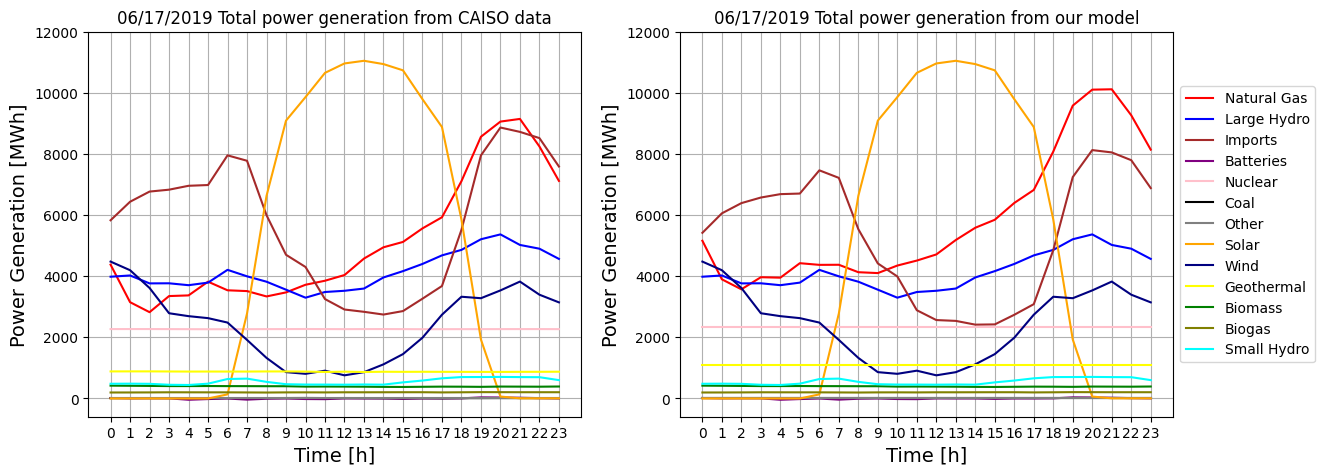

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14,5))
x = [i for i in range(0, 24, 1)]
ax1.set_xlabel('Time [h]', fontsize=14)
ax1.set_ylabel('Power Generation [MWh]', fontsize=14)
ax2.set_xlabel('Time [h]', fontsize=14)
ax2.set_ylabel('Power Generation [MWh]', fontsize=14)
ax1.plot(x, actual_supply[0], label='Natural Gas', color='red')
ax1.plot(x, actual_supply[1], label='Large Hydro', color='blue')
ax1.plot(x, actual_supply[2], label='Imports', color='brown')
ax1.plot(x, actual_supply[3], label='Batteries', color='purple')
ax1.plot(x, actual_supply[4], label='Nuclear', color='pink')
ax1.plot(x, actual_supply[5], label='Coal', color='black')
ax1.plot(x, actual_supply[6], label='Other', color='grey')
ax1.plot(x, actual_supply[7], label='Solar', color='orange')
ax1.plot(x, actual_supply[8], label='Wind', color='navy')
ax1.plot(x, actual_supply[9], label='Geothermal', color='yellow')
ax1.plot(x, actual_supply[10], label='Biomass', color='green')
ax1.plot(x, actual_supply[11], label='Biogas', color='olive')
ax1.plot(x, actual_supply[12], label='Small Hydro', color='cyan')
#fig.text(0.5, 0.04, 'Time', ha='center', va='center', fontsize=16)
#fig.text(0.06, 0.5, 'MWh', ha='center', va='center', rotation='vertical', fontsize=16)
ax1.grid()
ax1.set_xticks([i for i in range(0,24,1)])
ax1.set_yticks([0,2000,4000,6000,8000,10000,12000])
ax1.set_title("06/17/2019 Total power generation from CAISO data")
ax2.plot(x, pg_time_by_type[0], label='Natural Gas', color='red')
ax2.plot(x, actual_supply[1], label='Large Hydro', color='blue')
ax2.plot(x, imports_pg, label='Imports', color='brown')
ax2.plot(x, actual_supply[3], label='Batteries', color='purple')
ax2.plot(x, pg_time_by_type[4], label='Nuclear', color='pink')
ax2.plot(x, pg_time_by_type[5], label='Coal', color='black')
ax2.plot(x, pg_time_by_type[6], label='Other', color='grey')
ax2.plot(x, actual_supply[7], label='Solar', color='orange')
ax2.plot(x, actual_supply[8], label='Wind', color='navy')
ax2.plot(x, pg_time_by_type[9], label='Geothermal', color='yellow')
ax2.plot(x, actual_supply[10], label='Biomass', color='green')
ax2.plot(x, actual_supply[11], label='Biogas', color='olive')
ax2.plot(x, actual_supply[12], label='Small Hydro', color='cyan')
ax2.set_xticks([i for i in range(0,24,1)])
ax2.set_yticks([0,2000,4000,6000,8000,10000,12000])
ax2.set_title("06/17/2019 Total power generation from our model")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid()
#fig.tight_layout()